##### Trevor Deppermann and Jessie Kong
CSE 5524 - 12:45 PM

### CSE 5524 – Virtual Drum Kit Project

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage import io

In [2]:
# Show desired image
def display(im):
    plt.figure()
    io.imshow(im, cmap='gray')
    plt.show()

In [3]:
# Load images
images = []
for i in range(0, 90):
    # Read in frames in grayscale
    images.append(skimage.color.rgb2gray(io.imread('frames/drums_video' + str(i).zfill(4) + '.png')))

In [4]:
def ncc(search, template):
    # Save dimensions of template and search images
    t_rows, t_cols = template.shape
    rows, cols = search.shape
    print(template.shape)
    # Calculate number of rows above and columns left of patch center
    row_offset = t_rows // 2
    col_offset = t_cols // 2

    similarities = []

    # Calculate mean intensity value for template pixels
    t_vals = template.flatten()
    t_bar = np.mean(t_vals)
    t_std = np.std(t_vals, ddof=1)

    # Store NCC denominator, by which we divide values to get NCC result
    ncc_denom = 3 * (t_rows * t_cols - 1)

    # Iterate through all possible patches
    for center_row in range(row_offset, rows//6-row_offset):
        for center_col in range(col_offset, cols-col_offset):
            # Grab desired patch
            patch = search[center_row-row_offset:center_row+row_offset+1, center_col-col_offset:center_col+col_offset+1]
            p_vals = patch.flatten()

            # Calculate patch mean and standard deviation
            p_bar = np.mean(p_vals)
            p_std = np.std(p_vals, ddof=1)

            # Compute NCC similarity value
            if t_std != 0 and p_std != 0:
                new_vals = ((p_vals - p_bar) * (t_vals - t_bar)) / (p_std * t_std)
                ncc_val = np.sum(new_vals) / ncc_denom
            else:
                ncc_val = 0

            # Store NCC value with patch center
            similarities.append([ncc_val, center_row, center_col])

        # Print progress
        if (rows//6-row_offset-center_row) % 40 == 0:
            print("Rows remaining: ", rows//6-row_offset-center_row)

    # Sort patches from most to least similar
    similarities.sort(reverse=True)

    graph_data = []
    for data in similarities:
        graph_data.append(data[0])
    plt.plot(graph_data)
    plt.xlabel("k")
    plt.show()

    # Get best patch
    cr = similarities[0][1]
    cc = similarities[0][2]

    # Return position of best match
    return cr, cc

(29, 313)
Rows remaining:  200
Rows remaining:  160
Rows remaining:  120
Rows remaining:  80
Rows remaining:  40


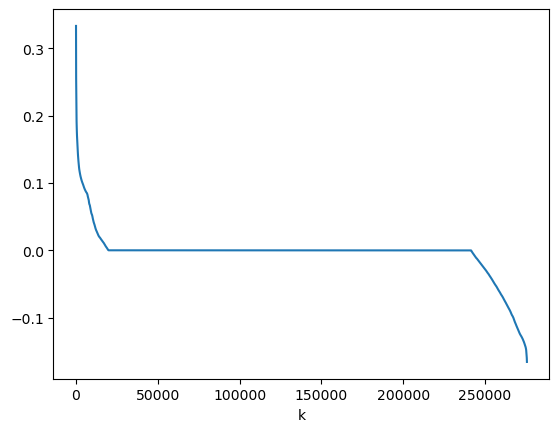

( 125 , 256 )


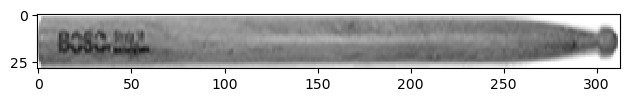

In [74]:
# Load in templates for light and dark drumsticks
template_light = skimage.color.rgb2gray(io.imread('original_images/drumstick_light.png')[:, :, :3])
template_dark = skimage.color.rgb2gray(io.imread('original_images/drumstick_dark.png')[:, :, :3])

# Calculate number of rows above and columns left of patch center
t_rows, t_cols = template_light.shape
row_offset = t_rows // 2
col_offset = t_cols // 2

# Perform NCC template matching for light drumstick
light_r, light_c = ncc(images[0], template_light)
print('(', light_r, ',', light_c, ')')

light_patch_im = images[0][light_r-row_offset:light_r+row_offset+1, light_c-col_offset:light_c+col_offset+1]
display(light_patch_im)

(29, 313)
Rows remaining:  200
Rows remaining:  160
Rows remaining:  120
Rows remaining:  80
Rows remaining:  40


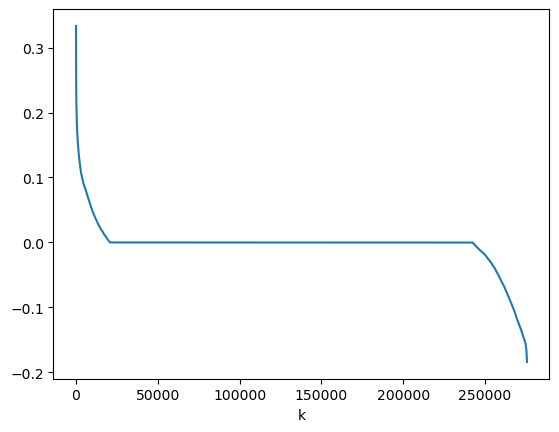

( 125 , 1344 )


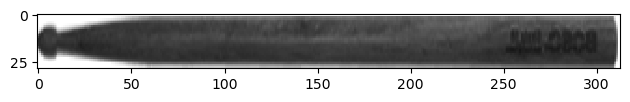

In [6]:
# Calculate number of rows above and columns left of patch center
t_rows, t_cols = template_dark.shape
row_offset = t_rows // 2
col_offset = t_cols // 2

# Perform NCC template matching for dark drumstick
dark_r, dark_c = ncc(images[0], template_dark)
print('(', dark_r, ',', dark_c, ')')

dark_patch_im = images[0][dark_r-row_offset:dark_r+row_offset+1, dark_c-col_offset:dark_c+col_offset+1]
display(dark_patch_im)

In [7]:
# Define helper methods for mean-shift tracking

# Return feature matrix for pixels in neighborhood
def circularNeighbors(img, x, y, radius):
    # Store fk value for each pixel in neighborhood
    fk_matrix = np.empty((0, 3), int)

    # Iterate through possible neighborhood pixels, instead of all image pixels
    for i in range(math.floor(x) - radius, math.ceil(x) + radius):
        for j in range(math.floor(y) - radius + 1, math.ceil(y) + radius):
            # Calculate distance from center
            dist = math.sqrt(pow(i - x, 2) + pow(j - y, 2))
            # Ensure distance is less than radius
            if dist < radius:
                # Extract pixel intensity
                intensity = img[i, j]
                # Calculate feature vector and add to matrix
                fk = [i, j, intensity]
                fk_matrix = np.vstack((fk_matrix, np.array(fk)))
                
    return fk_matrix


# Return bin index based on bounds and value
def get_bin(lower_bounds, val):
    for i in range(len(lower_bounds)-1, -1, -1):
        if val >= lower_bounds[i]:
            return i
    return -1


# Return histogram
def intensityHistogram(X, bins, x, y, h):
    # Initialize histogram
    hist = np.zeros(bins)

    # Determine lower bounds of each histogram bin
    bin_lower_bounds = np.linspace(0, 1, bins+1)[:-1]

    # Iterate through all pixels of neighborhood
    for i in range(len(X)):
        intensity = X[i, 2]
        # Calculate weight
        x_dist = x - X[i][0]
        y_dist = y - X[i][1]
        epan_val = pow(math.sqrt(x_dist*x_dist + y_dist*y_dist) / h, 2)

        if epan_val < 1:
            epan_val = 1 - epan_val
        else:
            epan_val = 0

        # Determine bin for color component
        bin_num = get_bin(bin_lower_bounds, intensity)

        hist[bin_num] += epan_val

    # Normalize histogram
    hist /= np.sum(hist)

    return hist


# Return vector of pixel weights
def meanshiftWeights(X, q_model, p_test, bins):
    # Determine size of each histogram bin
    bounds = np.linspace(0, 1, bins + 1)[:-1]

    # Store weight for each pixel in neighborhood
    w = []

    # Iterate through all bins
    for i in range(len(X)):
        val = X[i, 2]
        # Find bin of current pixel, then update weight
        bin_num = get_bin(bounds, val)
        wi = math.sqrt(q_model[bin_num] / p_test[bin_num])
        # Add pixel weight to vector
        w.append(wi)

    return w

In [8]:
# Use mean-shift tracking to return location of desired object in each frame
def get_locations_by_frame(im_seq, initial_row, initial_col):
    
    # Initialize list of locations per im_seq frame, to be returned
    locations = np.zeros((len(im_seq), 2))

    # Set parameters for mean-shift tracking
    radius = 100
    bins = 16

    # Set initial location
    loc = [initial_row, initial_col]
    locations[0] = loc
    print("0", loc)

    # Iterate through each image frame
    for im_num in range(1, len(im_seq)):
        
        # Build model histogram
        model_cn = circularNeighbors(im_seq[im_num-1], loc[0], loc[1], radius)
        model_hist = intensityHistogram(model_cn, bins, loc[0], loc[1], radius)

        # Perform mean-shift tracking on new image a certain number of times
        for iterations in range(25):
            candidate_cn = circularNeighbors(im_seq[im_num], loc[0], loc[1], radius)
            candidate_hist = intensityHistogram(candidate_cn, bins, loc[0], loc[1], radius)
            w = meanshiftWeights(candidate_cn, model_hist, candidate_hist, bins)
        
            # Perform mean shift - find next best location
            numerator = np.zeros(2)
            denominator = 0
            for i in range(len(candidate_cn)):
                numerator = numerator + [x * w[i] for x in candidate_cn[i, :2]]
                denominator += w[i]
        
            # Update location
            loc = numerator / denominator
        
        # Print results
        print(im_num, loc)
    
        # Save final location for frame
        locations[im_num] = loc

    return locations


In [9]:
light_stick_locations = get_locations_by_frame(images, light_r, light_c)
dark_stick_locations = get_locations_by_frame(images, dark_r, dark_c)

0 [125, 256]
1 [133.00514515 262.70277582]
2 [154.93263128 267.75168733]
3 [178.50155432 273.59708397]
4 [202.78965206 277.92564135]
5 [228.86201916 283.47890624]
6 [255.45721774 291.90909541]
7 [281.21341508 303.0666506 ]
8 [305.93645733 315.86302328]
9 [293.21548709 303.08666012]
10 [291.75620903 291.98308052]
11 [290.31523065 289.10698967]
12 [285.17920267 296.29848712]
13 [285.34576803 296.33174141]
14 [285.341306   296.34179815]
15 [285.33918299 296.3399008 ]
16 [285.33895515 296.33191466]
17 [285.34205188 296.33726899]
18 [285.34131538 296.33968002]
19 [285.33858192 296.33993763]
20 [285.35116632 296.32751066]
21 [285.33981195 296.35451753]
22 [285.33754644 296.34993203]
23 [305.40599139 282.69213178]
24 [299.9613388  282.56192624]
25 [341.71572091 252.54260009]
26 [354.05083563 248.32700753]
27 [364.47050686 239.82068215]
28 [377.08272958 225.80892207]


KeyboardInterrupt: 

In [ ]:
light_stick_locations = [[125, 256],
 [133.00514515, 262.70277582],
 [154.93263128, 267.75168733],
 [178.50155432, 273.59708397],
 [202.78965206, 277.92564135],
 [228.86201916, 283.47890624],
 [255.45721774, 291.90909541],
 [281.21341508, 303.0666506, ],
 [305.93645733, 315.86302328],
 [293.21548709, 303.08666012],
 [291.75620903, 291.98308052],
 [290.31523065, 289.10698967],
 [285.17920267, 296.29848712],
 [285.34576803, 296.33174141],
 [285.341306,   296.34179815],
 [285.33918299, 296.3399008, ],
 [285.33895515, 296.33191466],
 [285.34205188, 296.33726899],
 [285.34131538, 296.33968002],
 [285.33858192, 296.33993763],
 [285.35116632, 296.32751066],
 [285.33981195, 296.35451753],
 [285.33754644, 296.34993203],
 [305.40599139, 282.69213178],
 [299.9613388,  282.56192624],
 [341.71572091, 252.54260009],
 [354.05083563, 248.32700753],
 [364.47050686, 239.82068215],
 [377.08272958, 225.80892207],
 [390.00324947, 212.48763975],
 [398.54939401, 187.61910298],
 [408.03235879, 175.69716605],
 [421.11848155, 167.13744016],
 [435.28521021, 161.32065635],
 [450.03905489, 157.12307426],
 [473.68810739, 158.81416544],
 [470.03999575, 155.97687399],
 [471.48706985, 156.73412182],
 [472.85342246, 157.34885114],
 [473.64104342, 157.87638764],
 [474.27514275, 158.28548545],
 [474.38002119, 158.60468562],
 [474.25807912, 158.72159507],
 [473.47851478, 158.74496181],
 [472.25212415, 158.71260343],
 [470.41480777, 158.63022361],
 [468.07271219, 158.56934879],
 [464.57024337, 158.29506213],
 [461.30771323, 159.12830379],
 [457.26848316, 160.22752729],
 [452.55202066, 161.6053861, ],
 [468.75317385, 161.73426358],
 [473.82505713, 161.54376521],
 [470.26590121, 159.72240788],
 [438.14969389, 155.16125293],
 [416.70158458, 156.42037893],
 [382.98449151, 137.87922155],
 [367.76009008, 151.15009971],
 [353.2728558,  157.53509353],
 [370.91908051, 150.74415639],
 [385.69212469, 148.7515332, ],
 [394.67077243, 153.65130926],
 [402.294534,   160.67201285],
 [420.82251804, 169.12800822],
 [431.88201197, 141.09013322],
 [434.73729654, 142.51073897],
 [435.72797147, 143.15568892],
 [473.5684426,  140.21989638],
 [503.00401823, 150.68642831],
 [494.56022641, 131.56365226],
 [481.83573196, 134.71628144],
 [444.48882034, 137.12819236],
 [404.09555719, 154.48670951],
 [413.5800588,  146.85548423],
 [413.79129866, 143.40115329],
 [461.0875066,  157.95698609],
 [510.88078031, 157.60458745],
 [510.73291099, 157.49309292],
 [510.68777456, 157.4061867, ],
 [510.53989816, 157.32118923],
 [510.53860616, 157.2585268, ],
 [510.48605853, 157.24544391],
 [511.45671714, 159.7767294, ],
 [509.59967621, 159.4880471, ],
 [504.10257418, 159.69254096],
 [511.93333483, 163.35018769],
 [513.57933819, 163.27949376],
 [513.54314198, 163.31384871],
 [513.53880969, 163.32125963],
 [513.53863065, 163.32176249]]

dark_stick_locations = [[ 125, 344],
 [ 125.65010472, 1341.86385292],
 [ 133.58373985, 1339.24302722],
 [ 141.62835373, 1335.52685357],
 [ 147.15732766, 1332.12409053],
 [ 151.65092954, 1330.05033628],
 [ 158.43891337, 1327.83274541],
 [ 168.35844329, 1325.59510338],
 [ 176.55161817, 1327.80682226],
 [ 182.13956932, 1331.04129055],
 [ 183.39316836, 1322.44916098],
 [ 185.18919915, 1312.45229508],
 [ 186.04729879, 1306.85790547],
 [ 185.48962142, 1305.61910895],
 [ 185.48952438, 1305.65267811],
 [ 185.49097552, 1305.65414817],
 [ 185.49136694, 1305.65417546],
 [ 185.49147631, 1305.65417222],
 [ 185.49150699, 1305.654171,  ],
 [ 185.4915156,  1305.65417065],
 [ 185.49151801, 1305.65417055],
 [ 185.49151869, 1305.65417052],
 [ 185.49151888, 1305.65417051],
 [ 185.49151893, 1305.65417051],
 [ 185.49151895, 1305.65417051],
 [ 185.49151895, 1305.65417051],
 [ 185.49151895, 1305.65417051],
 [ 185.49151895, 1305.65417051],
 [ 185.49151895, 1305.65417051],
 [ 185.49151895, 1305.65417051],
 [ 185.49099124, 1305.65555149],
 [ 185.49056035, 1305.6535728, ],
 [ 185.49125655, 1305.65416321],
 [ 185.49144552, 1305.654173,  ],
 [ 177.40194698, 1327.82354673],
 [ 146.8717296,  1349.35027787],
 [ 145.48803589, 1357.64727968],
 [ 145.61965781, 1352.22125222],
 [ 146.48039314, 1347.02983516],
 [ 148.36917984, 1343.01172659],
 [ 149.85220861, 1341.38428443],
 [ 150.6872449,  1337.32862377],
 [ 149.92104961, 1331.74774789],
 [ 150.77381001, 1334.98261429],
 [ 151.70691485, 1337.82048618],
 [ 152.71368791, 1339.9260719, ],
 [ 152.89493068, 1340.2057732, ],
 [ 152.83442007, 1341.70114863],
 [ 156.728675,   1337.65166958],
 [ 163.44604014, 1331.8244378, ],
 [ 176.53703781, 1326.17276272],
 [ 185.28041598, 1319.50004362],
 [ 188.05253288, 1294.73552681],
 [ 190.58574626, 1278.57331503],
 [ 193.48394226, 1267.11430773],
 [ 196.55735957, 1251.85406715],
 [ 195.5082781,  1252.42187411],
 [ 195.51095363, 1252.34661093],
 [ 195.50925204, 1252.34591532],
 [ 195.50871646, 1252.34585476],
 [ 195.5085529,  1252.3458372, ],
 [ 195.50850298, 1252.34583184],
 [ 195.50848774, 1252.34583021],
 [ 195.50848309, 1252.34582971],
 [ 195.50848167, 1252.34582955],
 [ 195.50848124, 1252.34582951],
 [ 195.50848111, 1252.34582949],
 [ 195.50848107, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949],
 [ 195.50848105, 1252.34582949]]

In [10]:
def nccDrums(search, template):
    # Save dimensions of template and search images
    t_rows, t_cols = template.shape
    rows, cols = search.shape
    # Calculate number of rows above and columns left of patch center
    row_offset = t_rows // 2
    col_offset = t_cols // 2

    similarities = []

    # Calculate mean intensity value for template pixels
    t_vals = template.flatten()
    t_bar = np.mean(t_vals)
    t_std = np.std(t_vals, ddof=1)

    # Store NCC denominator, by which we divide values to get NCC result
    ncc_denom = 3 * (t_rows * t_cols - 1)

    # Iterate through all possible patches
    for center_row in range(row_offset, rows-row_offset):
        for center_col in range(col_offset, cols-col_offset):
            # Grab desired patch
            patch = search[center_row-row_offset:center_row+row_offset+1, center_col-col_offset:center_col+col_offset+1]
            p_vals = patch.flatten()

            # Calculate patch mean and standard deviation
            p_bar = np.mean(p_vals)
            p_std = np.std(p_vals, ddof=1)

            # Compute NCC similarity value
            if t_std != 0 and p_std != 0:
                new_vals = ((p_vals - p_bar) * (t_vals - t_bar)) / (p_std * t_std)
                ncc_val = np.sum(new_vals) / ncc_denom
            else:
                ncc_val = 0

            # Store NCC value with patch center
            similarities.append([ncc_val, center_row, center_col])

        # Print progress
        if (rows - row_offset) % 40 == 0:
            print("Rows remaining: ", rows - row_offset)

    # Sort patches from most to least similar
    similarities.sort(reverse=True)

    graph_data = []
    for data in similarities:
        graph_data.append(data[0])
    plt.plot(graph_data)
    plt.xlabel("k")
    plt.show()

    # Get best patch
    cr = similarities[0][1]
    cc = similarities[0][2]

    # Return position of best match
    return cr, cc



In [11]:
#original = original image, search = area of image to search in, template = image to find
#returns dictionary with coordinates for the found image {'x-min': value,'x-max': value, 'y-min':value, 'y-max':value}
def getCoordsLeft(original, search, template):
    
    #Perform NCC template matching for snare drum
    r, c = nccDrums(search, template)
    t_rows, t_cols = template.shape
    row_offset = t_rows // 2
    col_offset = t_cols // 2
    
    # Translate the coordinates to the full image coordinates
    full_image_r = r + (original.shape[0] // 5) 
    full_image_c = c

    
    #save snare coordinates
    coordinates = {
        'x-min': full_image_r - row_offset,
        'x-max': full_image_r + row_offset + 1,
        'y-min': full_image_c - col_offset,
        'y-max': full_image_c + col_offset +1
    }
    return coordinates;

In [12]:
def getCoordsRight(original, search, template):
    
    #Perform NCC template matching for snare drum
    r, c = nccDrums(search, template)
    t_rows, t_cols = template.shape
    row_offset = t_rows // 2
    col_offset = t_cols // 2
    
    # Translate the coordinates to the full image coordinates
    full_image_r = r + (original.shape[0] // 7) 
    full_image_c = c + (original.shape[1] // 2)

    
    #save snare coordinates
    coordinates = {
        'x-min': full_image_r - row_offset,
        'x-max': full_image_r + row_offset + 1,
        'y-min': full_image_c - col_offset,
        'y-max': full_image_c + col_offset +1
    }
    return coordinates;

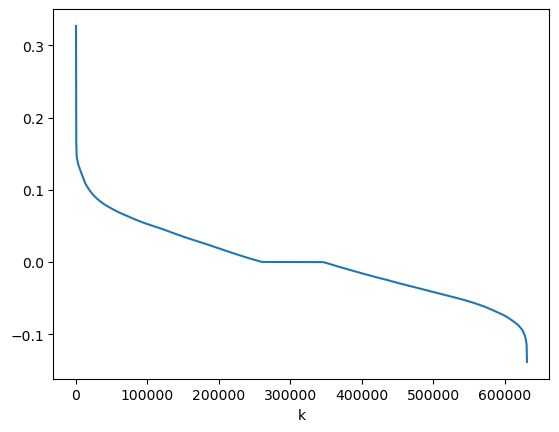

Hi Hat Region:  {'x-min': 432, 'x-max': 483, 'y-min': 182, 'y-max': 417}


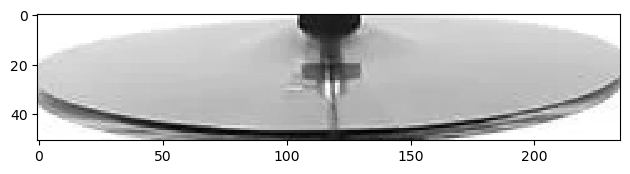

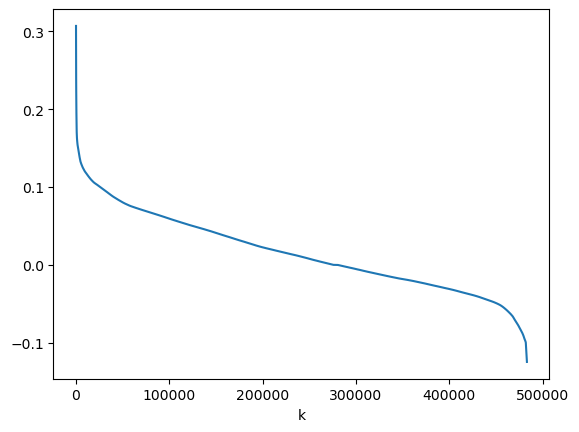

Snare Region:  {'x-min': 584, 'x-max': 739, 'y-min': 70, 'y-max': 393}


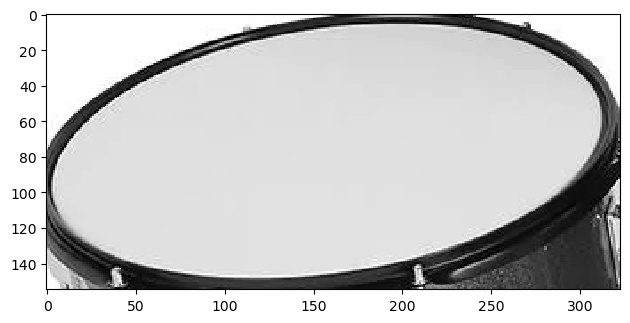

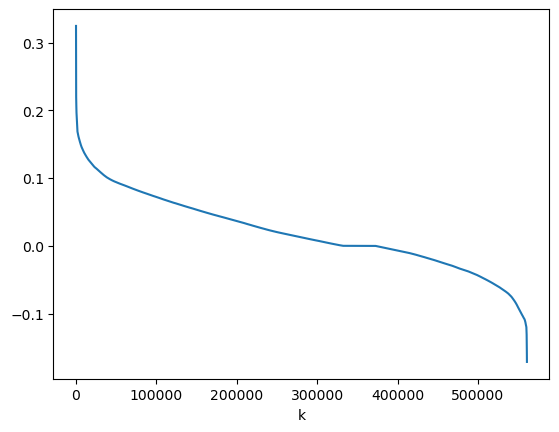

Left Tom Region:  {'x-min': 428, 'x-max': 511, 'y-min': 431, 'y-max': 714}


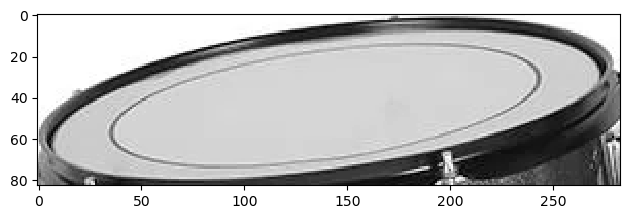

In [13]:
#initialize left side drum kit

#load in templates for snare, hihat, and left-tom drums
template_snare = skimage.color.rgb2gray(io.imread('original_images/snare.jpeg')[:, :, :3])
template_hihat = skimage.color.rgb2gray(io.imread('original_images/hihat.jpeg')[:, :, :3])
template_lefttom = skimage.color.rgb2gray(io.imread('original_images/lefttom.jpeg')[:, :, :3])


#get search image patch for left side of drumset to decrease search time
main_rows = images[0].shape[0]
main_col = images[0].shape[1]
left_search_area = images[0][main_rows//5:main_rows, 0:main_col//2]


#get hihat region
hihat_coords = getCoordsLeft(images[0], left_search_area, template_hihat)
hihat_im = images[0][hihat_coords['x-min']:hihat_coords['x-max'], hihat_coords['y-min']:hihat_coords['y-max']]
print('Hi Hat Region: ', hihat_coords)
display(hihat_im)

#get snare region
snare_coords = getCoordsLeft(images[0], left_search_area, template_snare)
snare_im = images[0][snare_coords['x-min']:snare_coords['x-max'], snare_coords['y-min']:snare_coords['y-max']]
print('Snare Region: ', snare_coords)
display(snare_im)

#get left tom region
lefttom_coords = getCoordsLeft(images[0], left_search_area, template_lefttom)
lefttom_im = images[0][lefttom_coords['x-min']:lefttom_coords['x-max'], lefttom_coords['y-min']:lefttom_coords['y-max']]
print('Left Tom Region: ', lefttom_coords)
display(lefttom_im)

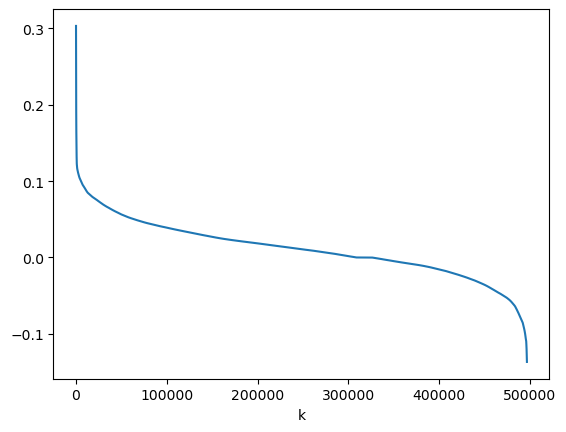

Floor Tom Region:  {'x-min': 681, 'x-max': 796, 'y-min': 1103, 'y-max': 1466}


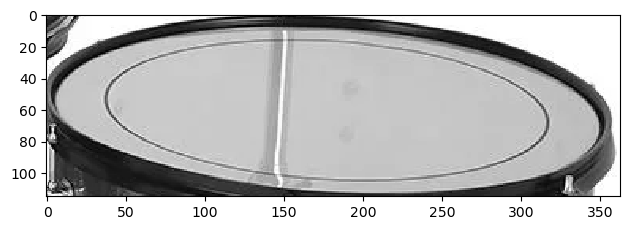

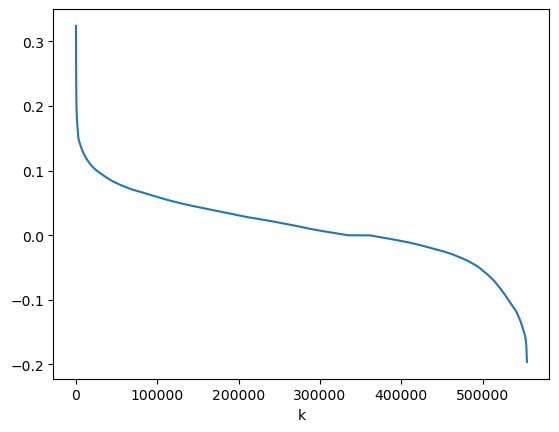

Right Tom Region:  {'x-min': 401, 'x-max': 514, 'y-min': 857, 'y-max': 1170}


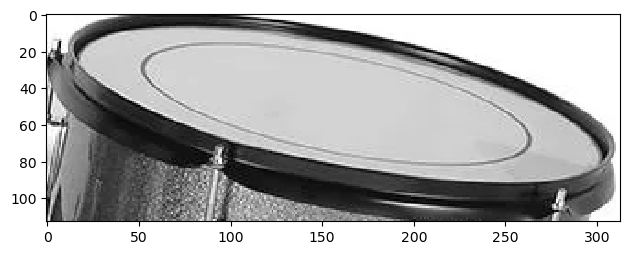

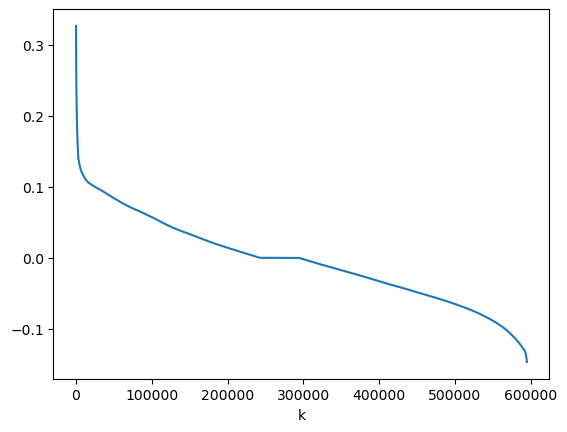

Crash Cymbal Region:  {'x-min': 230, 'x-max': 321, 'y-min': 1131, 'y-max': 1418}


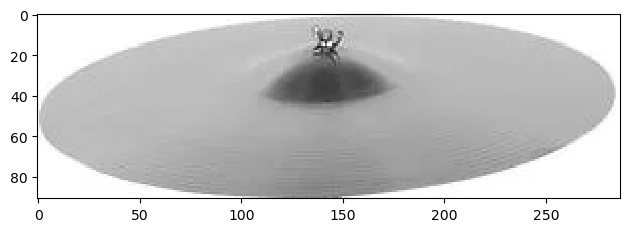

In [14]:
#initialize right side of the drum set

#load in templates for snare, hihat, and left-tom drums
temp_righttom = skimage.color.rgb2gray(io.imread('original_images/righttom.jpeg')[:, :, :3])
temp_floortom = skimage.color.rgb2gray(io.imread('original_images/floortom.jpeg')[:, :, :3])
temp_crash = skimage.color.rgb2gray(io.imread('original_images/crash.jpeg')[:, :, :3])

#reshape templates for NCC search
template_righttom = temp_righttom[0:113, 0:313]
template_floortom = temp_floortom[0:115, 0:363]
template_crash = temp_crash[0:91, 0:287]

#get search image patch for right side of drumset to decrease search time
main_rows = images[0].shape[0]
main_col = images[0].shape[1]
right_search_area = images[0][main_rows//7:main_rows, main_col//2:main_col]

#get floortom region
floortom_coords = getCoordsRight(images[0], right_search_area, template_floortom)
floortom_im = images[0][floortom_coords['x-min']:floortom_coords['x-max'], floortom_coords['y-min']:floortom_coords['y-max']]
print('Floor Tom Region: ', floortom_coords)
display(floortom_im)

#get righttom region
righttom_coords = getCoordsRight(images[0], right_search_area, template_righttom)
righttom_im = images[0][righttom_coords['x-min']:righttom_coords['x-max'], righttom_coords['y-min']:righttom_coords['y-max']]
print('Right Tom Region: ', righttom_coords)
display(righttom_im)

#get crash region
crash_coords = getCoordsRight(images[0], right_search_area, template_crash)
crash_im = images[0][crash_coords['x-min']:crash_coords['x-max'], crash_coords['y-min']:crash_coords['y-max']]
print('Crash Cymbal Region: ', crash_coords)
display(crash_im)



In [58]:
def gaussDeriv2D(sigma):
    size = math.ceil(3*sigma)
    origin = math.floor(size/2)
    Gx = np.fromfunction(lambda y,x: (-(x-origin)/(2*np.pi*(sigma**4)))*np.exp((-((x-origin)**2+(y-origin)**2)/(2*sigma**2))), (size,size), dtype = float)
    Gy = Gx.transpose()
    #normalize Gx and Gy
    Gx /= np.sum(np.abs(Gx))
    Gy /= np.sum(np.abs(Gy))
    return Gx,Gy

In [ ]:
from skimage import filters
har
    sigma = 0.7
    Gx, Gy = gauss_deriv_2d(sigma)
    gxIm = scipy.ndimage.convolve(light_patch_im, Gx, mode='nearest')
    gyIm = scipy.ndimage.convolve(light_patch_im, Gy, mode='nearest')
    #get image derivatives
    gxImSquared = gxIm*gxIm
    gyImSquared = gyIm*gyIm
    gxGy = gxIm*gyIm

    #blur image derivates
    Ix = filters.gaussian(gxImSquared, sigma=1)
    Iy = filters.gaussian(gyImSquared, sigma=1)
    IxIy = filters.gaussian(gxGy, sigma=1)


    #calculate R
    alpha = 0.0005
    R = (Ix*Iy) - (IxIy**2) - alpha*(Ix+Iy)**2

    #set threshold 
    RThreshold = np.copy(R)
    RThreshold [RThreshold < .00001 ] = 0  

    #get index of max value in RThreshold (drumstick tip)
    index = np.argmax(RThreshold)
    #get coordinates of index
    drumstick_tip = np.unravel_index(max_index_flat, RThreshold.shape) 

    print(f'Coordinates of the tip of drumstick: {drumstick_tip[1]},{drumstick_tip[0]}')

    #display the corner point detected
    plt.imshow(light_patch_im, cmap='gray')
    plt.scatter(drumstick_tip[1], drumstick_tip[0], c='r', s=40) 
    plt.title('Maximum Value Location')
    plt.show()
    #display the corner point detected
    plt.imshow(images[0], cmap='gray')
    plt.scatter(drumstick_tip[1] + light_r, drumstick_tip[0] + light_c , c='r', s=40) 
    plt.title('Maximum Value Location')
    plt.show()

In [237]:
#harris detector
from skimage import filters
def harrisDetector(image, template, r, c):
    sigma = 0.7
    Gx, Gy = gauss_deriv_2d(sigma)
    gxIm = scipy.ndimage.convolve(image, Gx, mode='nearest')
    gyIm = scipy.ndimage.convolve(image, Gy, mode='nearest')
    #get image derivatives
    gxImSquared = gxIm*gxIm
    gyImSquared = gyIm*gyIm
    gxGy = gxIm*gyIm

    #blur image derivates
    Ix = filters.gaussian(gxImSquared, sigma=1)
    Iy = filters.gaussian(gyImSquared, sigma=1)
    IxIy = filters.gaussian(gxGy, sigma=1)


    #calculate R
    alpha = 0.0005
    R = (Ix*Iy) - (IxIy**2) - alpha*(Ix+Iy)**2

    #set threshold 
    RThreshold = np.copy(R)
    RThreshold [RThreshold < .00001 ] = 0  
    plt.imshow(RThreshold, cmap='gray')
    plt.title("Harris Detector with Threshold")
    plt.show()
    #get index of max value in RThreshold (drumstick tip)
    index = np.argmax(RThreshold)
    #get coordinates of index
    drumstick_tip = np.unravel_index(max_index_flat, RThreshold.shape) 

    #display the corner point detected
    plt.imshow(image, cmap='gray')
    plt.scatter(drumstick_tip[1], drumstick_tip[0], c='r', s=40) 
    plt.title('Point in Template')
    plt.show()
    # Calculate number of rows above and columns left of patch center
    t_rows, t_cols = template.shape
    row_offset = t_rows // 2
    col_offset = t_cols // 2
    x_val = drumstick_tip[1] + c - col_offset -1
    y_val = drumstick_tip[0] + r - row_offset -1
    return x_val, y_val

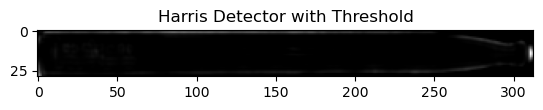

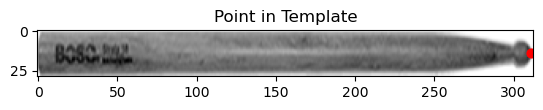

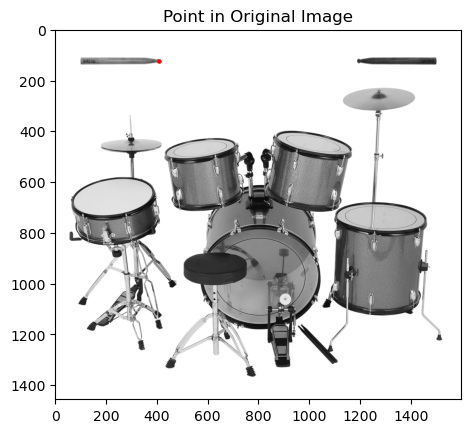

In [238]:
#Get interesting point for light drumstick 
light_x_val,light_y_val = harrisDetector(light_patch_im, template_light, light_r, light_c)
#display point detected
plt.imshow(images[0], cmap='gray')
plt.scatter(light_x_val, light_y_val , c='r', s=5) 
plt.title('Point in Original Image')
plt.show()



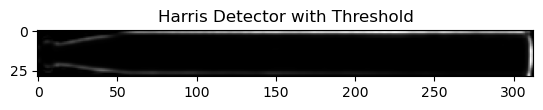

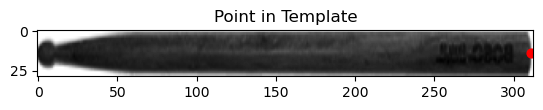

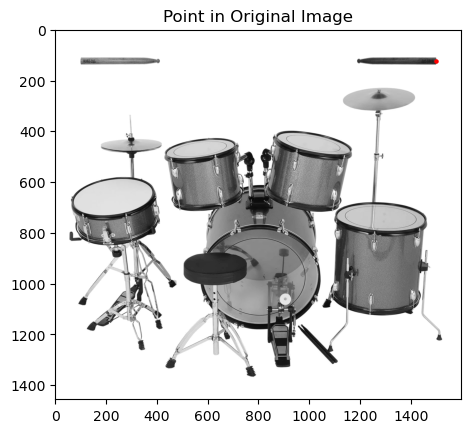

In [239]:
# Get interesting point for dark drum stick
dark_x_val,dark_y_val = harrisDetector(dark_patch_im, template_dark, dark_r, dark_c)
#display the point detected
plt.imshow(images[0], cmap='gray')
plt.scatter(dark_x_val, dark_y_val , c='r', s=5) 
plt.title('Point in Original Image')
plt.show()